In [1]:
import tensorflow as tf
import numpy as np
import math
from tqdm import tqdm
import pickle

# Import MINST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [2]:
## Build Model

models_path = '/home/Winston/tensorflow_models/MNIST_2Conv_1FC_Lite'

# Parameters
learning_rate = 0.01
training_epochs = 5
batch_size = 10
display_step = 1
log_step = 100

# Network Parameters
n_input_xs = 28
n_input_ys = 28
n_input = n_input_xs * n_input_ys  # MNIST data input (img shape: 28*28)
n_output = 10  # MNIST total classes (0-9 digits)
n_fc_1 = 100   # 1st fully-connected layer number of features
patch_sz = 5   # convolution patch size 5x5 
n_conv_1 = 20  # convolution layer1 output channels
n_conv_2 = 40  # convolution layer2 output channels

# Helper functions
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1], padding='SAME')

def nn_layer(input_tensor, input_dim, output_dim, layer_name, act=tf.nn.relu):
    # Adding a name scope ensures logical grouping of the layers in the graph.
    with tf.name_scope(layer_name):
        with tf.name_scope('weights'):
            weights = weight_variable([input_dim, output_dim]) 
        with tf.name_scope('biases'):
            biases = bias_variable([output_dim])
        with tf.name_scope('Wx_plus_b'):
            preactivate = tf.matmul(input_tensor, weights) + biases
            
        activations = act(preactivate, 'activation') if act != None else preactivate
        return activations

def conv_layer(input_tensor, in_channel, out_channel, layer_name, act=tf.nn.relu):
    # Adding a name scope ensures logical grouping of the layers in the graph.
    with tf.name_scope(layer_name):
        with tf.name_scope('weights'):
            weights = weight_variable([patch_sz, patch_sz, in_channel, out_channel]) 
        with tf.name_scope('biases'):
            biases = bias_variable([out_channel])
        with tf.name_scope('Wx_plus_b'):
            preactivate = conv2d(input_tensor, weights) + biases
            conv_activations = act(preactivate, 'activation')
        
        maxpool_activations = max_pool_2x2(conv_activations)
        return maxpool_activations

# TF Graph Input, Output and Dropout placeholders
x = tf.placeholder(tf.float32, [None, n_input_xs * n_input_ys], name='InputData')
y_ = tf.placeholder(tf.float32, [None, n_output], name='LabelData') 

def build_model(input_tensor):
    # 1st Convolutional Layer (5x5 patch size, 1 input channel, 32 output channels, 2x2 maxpooling)
    x_image = tf.reshape(input_tensor, [-1, n_input_xs, n_input_ys, 1])    
    xs = n_input_xs // 2
    ys = n_input_ys // 2
    layer_1 = conv_layer(x_image, 1, n_conv_1, 'layer1') # outputs: n_conv_1 * xs * ys
    
    # 2nd Convolutional Layer (5x5 patch size, 32 input channel, 64 output channels, 2x2 maxpooling)
    xs = xs // 2
    ys = ys // 2
    layer_2 = conv_layer(layer_1, n_conv_1, n_conv_2, 'layer2') # outputs: n_conv_1 * xs * ys
    layer_2_flat = tf.reshape(layer_2, [-1, n_conv_2*xs*ys])
    
    # Full-Connected Layer with Dropout
    layer_3 = nn_layer(layer_2_flat, n_conv_2*xs*ys, n_fc_1, 'layer3')
    
    # Output Layer
    layer_4 = nn_layer(layer_3, n_fc_1, n_output, 'layer4', act=None)
    return layer_4

# Encapsulating all ops into scopes, making Tensorboard's Graph visualization more convenient
with tf.name_scope('Model'):
    # Build model
    pred = build_model(x)

with tf.name_scope('Loss'):
    # Softmax Cross entropy (cost function)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(pred, y_))
    # NOTE:
    # Since out_layer has NOT invoked softmax, leverage TF optimized function 
    # "softmax_cross_entropy_with_logits" to calculate cost

with tf.name_scope('SGD'):
    # Gradient Descent
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    train_step = optimizer.minimize(loss)    

with tf.name_scope('Accuracy'):
    # Accuracy
    accuracy = tf.equal(tf.argmax(pred, 1), tf.argmax(y_, 1))
    accuracy = tf.reduce_mean(tf.cast(accuracy, tf.float32))

In [3]:
## Training

# Initializing the variables
init = tf.initialize_all_variables()

saver = tf.train.Saver()

train_cost_history, validation_cost_history, validation_accuracy_history = ([] for i in range(3))

with tf.Session() as sess:
    sess.run(init)
    log_avg_costs = list()
    # Training cycle
    for epoch in tqdm(range(training_epochs), ascii=True): 
        epoch_avg_cost = 0.
        total_batch = int(mnist.train.num_examples / batch_size)
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            train_cost, _ = sess.run([loss, train_step], feed_dict={x: batch_xs, y_: batch_ys})
            epoch_avg_cost += train_cost / total_batch
            log_avg_costs.append(train_cost)
            if (i+1) % log_step == 0:
                train_cost_history.append(np.mean(log_avg_costs))
                log_avg_costs[:] = []
                val_cost, val_accuracy = sess.run([loss, accuracy], feed_dict={x: mnist.validation.images, y_: mnist.validation.labels})
                validation_cost_history.append(val_cost)
                validation_accuracy_history.append(val_accuracy)
        
        # Display training cost & validation accuracy per epoch step
        if (epoch+1) % display_step == 0:
            print("Epoch: {}, cost= {:.9f}".format(epoch+1, epoch_avg_cost))

    print("Optimization Finished!")  
    save_path = saver.save(sess, models_path + '/model-5epochs.ckpt')
    print("Model save in file: %s" % save_path)
    with open(models_path + '/history-5epochs.pickle', "wb") as f:
        pickle.dump((train_cost_history, validation_cost_history, validation_accuracy_history), f)
        
    # Test model
    # Calculate accuracy
    mnist_test = mnist.test
    mnist = None
    print("Test Accuracy:", sess.run(accuracy, feed_dict={x: mnist_test.images, y_: mnist_test.labels}))

 20%|##        | 1/5 [05:44<22:59, 344.99s/it]

Epoch: 1, cost= 0.197174920


 40%|####      | 2/5 [11:30<17:15, 345.20s/it]

Epoch: 2, cost= 0.071338141


 60%|######    | 3/5 [17:16<11:30, 345.34s/it]

Epoch: 3, cost= 0.049740473


 80%|########  | 4/5 [23:00<05:45, 345.11s/it]

Epoch: 4, cost= 0.039585915


100%|##########| 5/5 [28:46<00:00, 345.22s/it]

Epoch: 5, cost= 0.031738063
Optimization Finished!


Model save in file: /home/Winston/tensorflow_models/MNIST_2Conv_1FC_Lite/model-5epochs.ckpt
('Test Accuracy:', 0.9853)


In [ ]:
# Restore Model to test Only
# Need to go through cell [1] & [2] first
train_cost_history, validation_cost_history, validation_accuracy_history = ([] for i in range(3))

saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, models_path + '/model-5epochs.ckpt')
    print("Model restored.")
    # just a workaround to reduce memory first
    mnist_test = mnist.test
    mnist = None
    # Calculate accuracy
    print("Test Accuracy:", sess.run(accuracy, feed_dict={x: mnist_test.images, y_: mnist_test.labels}))
    with open(models_path + '/history-5epochs.pickle', "rb") as f:
        train_cost_history, validation_cost_history, validation_accuracy_history = pickle.load(f)    

In [ ]:
# Restore Model to further train
# Need to go through cell [1] & [2] first
train_cost_history, validation_cost_history, validation_accuracy_history = ([] for i in range(3))

saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, models_path + '/model-5epochs.ckpt')
    with open(models_path + '/history-5epochs.pickle', "rb") as f:
        train_cost_history, validation_cost_history, validation_accuracy_history = pickle.load(f)
    print("Model and history restored.")    

    log_avg_costs = list()
    # Training cycle
    for epoch in tqdm(range(training_epochs), ascii=True): 
        epoch_avg_cost = 0.
        total_batch = int(mnist.train.num_examples / batch_size)
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            train_cost, _ = sess.run([loss, train_step], feed_dict={x: batch_xs, y_: batch_ys})
            epoch_avg_cost += train_cost / total_batch
            log_avg_costs.append(train_cost)
            if (i+1) % log_step == 0:
                train_cost_history.append(np.mean(log_avg_costs))
                log_avg_costs[:] = []
                val_cost, val_accuracy = sess.run([loss, accuracy], feed_dict={x: mnist.validation.images, y_: mnist.validation.labels})
                validation_cost_history.append(val_cost)
                validation_accuracy_history.append(val_accuracy)
        
        # Display training cost & validation accuracy per epoch step
        if (epoch+1) % display_step == 0:
            print("Epoch: {}, cost= {:.9f}".format(epoch+1, epoch_avg_cost))

    print("Optimization Finished!")  
    save_path = saver.save(sess, models_path + '/model-5epochs.ckpt')
    print("Model save in file: %s" % save_path)
    with open(models_path + '/history-5epochs.pickle', "wb") as f:
        pickle.dump((train_cost_history, validation_cost_history, validation_accuracy_history), f)
        
    # Test model
    # just a workaround to reduce memory first
    mnist_test = mnist.test
    mnist = None
    # Calculate accuracy
    print("Test Accuracy:", sess.run(accuracy, feed_dict={x: mnist_test.images, y_: mnist_test.labels}))    
    

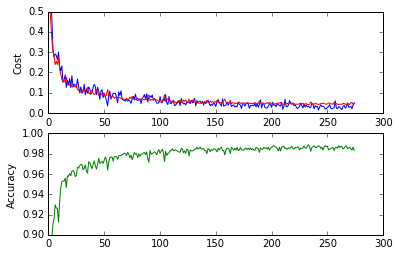

In [4]:
## Plot the learning curves

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fig = plt.figure() 
# create figure window
gs = gridspec.GridSpec(2, 1)
# Creates grid 'gs' of 2 rows and 1 columns 
ax = plt.subplot(gs[0, 0])
# Adds subplot 'ax' in grid 'gs' at position [0,0]
ax.set_ylabel('Cost') 
ax.set_xlabel('Iterations') 
ax.plot(train_cost_history, 'b-')
ax.plot(validation_cost_history, 'r-')
ax.set_ylim([0, 0.5])
fig.add_subplot(ax) 

bx = plt.subplot(gs[1, 0])
bx.set_ylabel('Accuracy') 
bx.plot(validation_accuracy_history, 'g-')
bx.set_ylim([0.9, 1.0])
fig.add_subplot(bx) 


(0.9, 1.0)

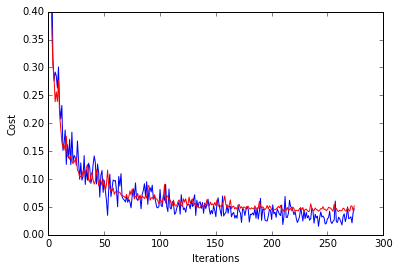

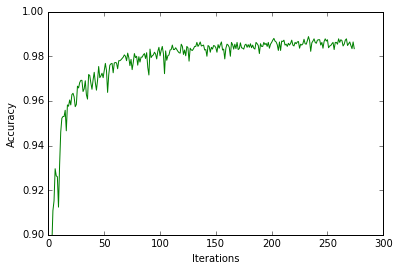

In [5]:
## Plot the learning curves

%matplotlib inline
import matplotlib.pyplot as plt
import pylab

plt.figure(1)
plt.plot(train_cost_history,'b-')
plt.plot(validation_cost_history, 'r-')
plt.ylabel('Cost')
plt.xlabel('Iterations')
pylab.ylim([0,0.4])

plt.figure(2)
plt.plot(validation_accuracy_history, 'g-')
plt.ylabel('Accuracy')
plt.xlabel('Iterations')
pylab.ylim([0.9,1.0])

In [6]:
print(validation_accuracy_history[-1])

0.9834
